In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Scikit-learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Local project imports
from preprocessing import prepare_data

# Experiment config
ratios = [0.1, 0.5, 1.0]
k_values = [3, 5, 7]   # optional hyperparameter sweep
random_state = 42

results = []

In [2]:
train_df = pd.read_csv("fraudTrain.csv")
test_df = pd.read_csv("fraudTest.csv")

print(f"Train shape: {train_df.shape} | Test shape: {test_df.shape}")
print("Fraud ratio (train):", train_df["is_fraud"].mean())
print("Fraud ratio (test):", test_df["is_fraud"].mean())


Train shape: (1296675, 23) | Test shape: (555719, 23)
Fraud ratio (train): 0.005788651743883394
Fraud ratio (test): 0.0038598644278853163


In [3]:
out_train_init = prepare_data(
    train_df,
    mode="distance",
    training=True,
    ratio=0.1,
    fit=True
)
encoders = out_train_init["encoders"]
scalers = out_train_init["scalers"]

out_test = prepare_data(
    test_df,
    mode="distance",
    training=False,
    fit=False,
    encoders=encoders,
    scalers=scalers
)
df_test = out_test["df"]
X_test = df_test.drop("is_fraud", axis=1)
y_test = df_test["is_fraud"]

print("Test set shape:", X_test.shape, "| Fraud ratio:", y_test.mean())


Test set shape: (555719, 25) | Fraud ratio: 0.0038598644278853163


In [4]:
import sys
import time
from datetime import datetime

# To avoid losing progress if run dies midway
partial_save_path = "results/knn_partial_results.csv"

for ratio_idx, ratio in enumerate(ratios, start=1):
    print(f"\n{'='*70}")
    print(f"[{datetime.now().strftime('%H:%M:%S')}] Starting ratio {ratio_idx}/{len(ratios)} → ratio={ratio}")
    sys.stdout.flush()
    start_ratio_time = time.time()

    # Prepare data
    out_train = prepare_data(
        train_df,
        mode="distance",
        training=True,
        ratio=ratio,
        fit=True
    )

    resample_type = "df_down"
    if resample_type not in out_train or out_train[resample_type] is None:
        print(f"⚠️ Skipping ratio={ratio} (no {resample_type} data)")
        continue

    df_train = out_train[resample_type]
    X_train = df_train.drop("is_fraud", axis=1)
    y_train = df_train["is_fraud"]

    print(f"  [{datetime.now().strftime('%H:%M:%S')}] → Training on {resample_type} (samples={len(X_train):,})")
    sys.stdout.flush()

    for k_idx, k in enumerate(k_values, start=1):
        print(f"    ⏳ Running KNN (k={k}) [{k_idx}/{len(k_values)}] ...", end="")
        sys.stdout.flush()
        start_k_time = time.time()

        model = KNeighborsClassifier(
            n_neighbors=k,
            algorithm="ball_tree",  # faster for moderately high dimensions
            n_jobs=-1               # parallelize across cores
        )
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)

        results.append({
            "ratio": ratio,
            "resample_type": resample_type.replace("df_", ""),
            "k": k,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "roc_auc": auc
        })

        print(f" done → F1={f1:.4f}, Recall={rec:.4f}, AUC={auc:.4f} "
              f"| Time={time.time() - start_k_time:.1f}s")
        sys.stdout.flush()

    # Save partial results after each ratio
    pd.DataFrame(results).to_csv(partial_save_path, index=False)
    print(f"  💾 Saved intermediate results → {partial_save_path}")
    print(f"  ✅ Completed ratio={ratio} in {(time.time() - start_ratio_time)/60:.1f} min")

print("\nAll ratios completed.")
print(f"Total experiments logged: {len(results)}")
print(f"Results saved at: {partial_save_path}")



[21:27:12] Starting ratio 1/3 → ratio=0.1
  [21:27:16] → Training on df_down (samples=82,566)
    ⏳ Running KNN (k=3) [1/3] ... done → F1=0.0256, Recall=0.0970, AUC=0.6184 | Time=28.0s
    ⏳ Running KNN (k=5) [2/3] ... done → F1=0.0285, Recall=0.0601, AUC=0.6517 | Time=32.5s
    ⏳ Running KNN (k=7) [3/3] ... done → F1=0.0278, Recall=0.0373, AUC=0.6760 | Time=34.6s
  💾 Saved intermediate results → results/knn_partial_results.csv
  ✅ Completed ratio=0.1 in 1.7 min

[21:28:51] Starting ratio 2/3 → ratio=0.5
  [21:29:01] → Training on df_down (samples=22,518)
    ⏳ Running KNN (k=3) [1/3] ... done → F1=0.0185, Recall=0.4438, AUC=0.6820 | Time=13.5s
    ⏳ Running KNN (k=5) [2/3] ... done → F1=0.0190, Recall=0.3967, AUC=0.7088 | Time=14.8s
    ⏳ Running KNN (k=7) [3/3] ... done → F1=0.0206, Recall=0.3855, AUC=0.7211 | Time=16.7s
  💾 Saved intermediate results → results/knn_partial_results.csv
  ✅ Completed ratio=0.5 in 0.9 min

[21:29:46] Starting ratio 3/3 → ratio=1.0
  [21:29:57] → Traini

,ratio,resample_type,k,accuracy,precision,recall,f1,roc_auc
0,0.1,down,5,0.984170,0.018669,0.060140,0.028493,0.651706
1,0.1,down,7,0.989936,0.022173,0.037296,0.027812,0.675993
2,0.1,down,3,0.971493,0.014738,0.096970,0.025587,0.618437
3,0.5,down,7,0.858628,0.010593,0.385548,0.020619,0.721080
4,0.5,down,5,0.841798,0.009729,0.396737,0.018992,0.708768
5,0.5,down,3,0.817872,0.009428,0.443823,0.018465,0.682013
6,1.0,down,7,0.676174,0.007686,0.647086,0.015192,0.717430
7,1.0,down,5,0.671566,0.007460,0.636830,0.014748,0.707382
8,1.0,down,3,0.665621,0.007407,0.643823,0.014646,0.688686


Saved to results/knn_results.csv


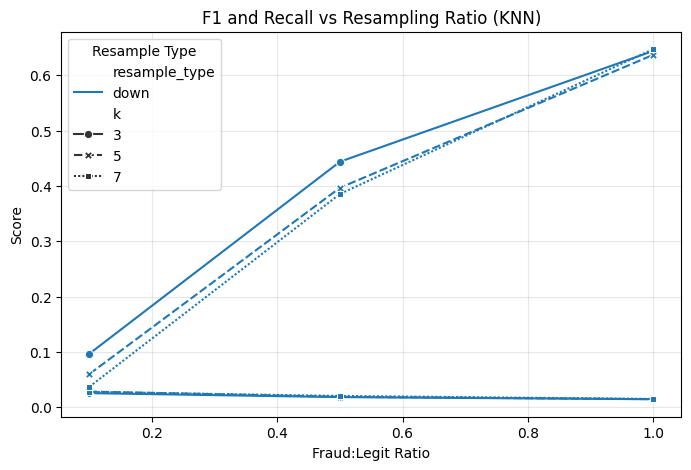

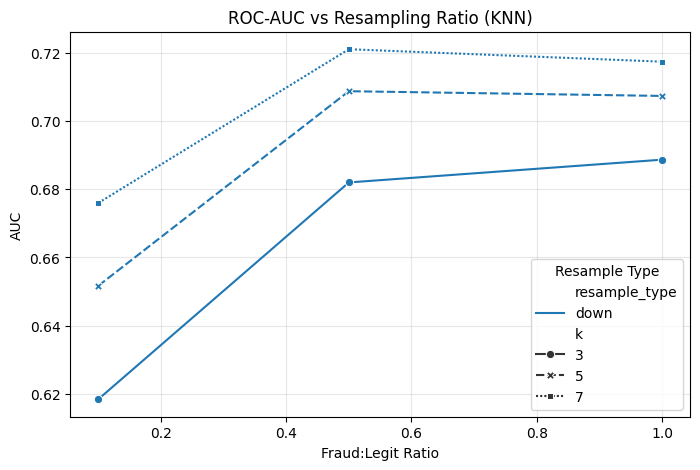

,,precision,recall,f1,roc_auc
ratio,resample_type,,,,
0.1,down,0.019,0.065,0.027,0.649
0.5,down,0.010,0.409,0.019,0.704
1.0,down,0.008,0.643,0.015,0.704


In [5]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="f1", ascending=False).reset_index(drop=True)
display(results_df.head(10))

results_df.to_csv("results/knn_results.csv", index=False)
print("Saved to results/knn_results.csv")

# ---- Plot F1 & Recall vs Ratio ----
plt.figure(figsize=(8,5))
sns.lineplot(data=results_df, x="ratio", y="f1", hue="resample_type", style="k", markers=True)
sns.lineplot(data=results_df, x="ratio", y="recall", hue="resample_type", style="k", markers=True, linestyle="--", legend=False)
plt.title("F1 and Recall vs Resampling Ratio (KNN)")
plt.xlabel("Fraud:Legit Ratio")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.legend(title="Resample Type")
plt.show()

# ---- Plot ROC-AUC vs Ratio ----
plt.figure(figsize=(8,5))
sns.lineplot(data=results_df, x="ratio", y="roc_auc", hue="resample_type", style="k", markers=True)
plt.title("ROC-AUC vs Resampling Ratio (KNN)")
plt.xlabel("Fraud:Legit Ratio")
plt.ylabel("AUC")
plt.grid(True, alpha=0.3)
plt.legend(title="Resample Type")
plt.show()

# ---- Optional: summary table for report ----
summary = results_df.groupby(["ratio", "resample_type"])[["precision", "recall", "f1", "roc_auc"]].mean().round(3)
display(summary)
